In [1]:
import os
import shutil
import tensorflow
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image

MUSHROOMS_PATH = 'mushrooms_dataset'

# Directory for the images and its subdirectories
images_dir = os.path.join(MUSHROOMS_PATH, 'images')
subdirs = [os.path.join(images_dir, subdir) for subdir in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, subdir))]



In [2]:
len(subdirs)

7720

Now we check whether the mushrooms actually belong to mushrooms (are in Fungi kingdom)

In [3]:
fungus_types_csv = pd.read_csv("mushrooms_dataset/name_classifications.csv", delimiter="\t")
fungus_types_df = pd.DataFrame(fungus_types_csv)
fungus_types_df 

,name_id,domain,kingdom,phylum,class,order,family
0,1,Eukarya,NaN,NaN,NaN,NaN,NaN
1,2,Eukarya,Fungi,Ascomycota,Sordariomycetes,Xylariales,Xylariaceae
2,3,Eukarya,Fungi,Ascomycota,Sordariomycetes,Xylariales,Xylariaceae
3,4,Eukarya,Fungi,Ascomycota,Sordariomycetes,Xylariales,Xylariaceae
4,5,Eukarya,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Mycenaceae
...,...,...,...,...,...,...,...
32325,113684,Eukarya,Protozoa,Myxomycota,NaN,Physarales,Didymiaceae
32326,113685,Eukarya,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Clavariaceae
32327,113686,Eukarya,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Ophiocordycipitaceae
32328,113687,Eukarya,Fungi,Basidiomycota,Agaricomycetes,Russulales,Russulaceae


In [4]:
non_fungus_types = fungus_types_df[fungus_types_df['kingdom'] != 'Fungi']
non_fungus_types['kingdom'].unique() # We see now that are some non-fungus types in the dataset

array([nan, 'Protozoa', 'Plantae', 'Animalia', 'Amoebozoa', 'Chromista',
       'Eubacteria', 'Anamalia', 'Bacteria'], dtype=object)

In [5]:
#We need to create a list of the fungus families that are not fungi
non_fungus_families = non_fungus_types['family'].unique()
non_fungus_families

array([nan, 'Physaraceae', 'Stemonitidaceae', 'Trichiaceae',
       'Tubiferaceae', 'Ceratiomyxaceae', 'Didymiaceae', 'Arcyriaceae',
       'Sarcosomataceae', 'Ericaceae', 'Orchidaceae', 'Teloschistaceae',
       'Saprolegniaceae', 'Peronosporaceae', 'Dictyosteliaceae',
       'Acrasiaceae', 'Thraustochytriaceae', 'Labyrinthulaceae',
       'Albuginaceae', 'Nostocaceae', 'Dictydiaethaliaceae',
       'Cribrariaceae', 'Nectriaceae', 'Cortinariaceae', 'Boletaceae',
       'Bolbitiaceae', 'Pythiaceae', 'Orobanchaceae', 'Liceaceae',
       'Stereaceae', 'Hygrophoraceae', 'Pinaceae', 'Eriophyidae',
       'Clastodermataceae', 'Dianemataceae', 'Echinosteliaceae',
       'Elaeomyxaceae', 'Listerellaceae', 'Guttulinaceae', 'Gurleyidae',
       'Adelgidae', 'Burmanniaceae', 'Fagaceae', 'Triuridaceae',
       'Cynipidae', 'Clavicipitaceae', 'Frankiaceae',
       'Enterobacteriaceae', 'Aytoniaceae', 'Rhizobiaceae',
       'Asterinaceae', 'Taphrinaceae', 'Tubeufiaceae', 'Pleomassariaceae',
       

In [6]:
non_fungus_types = non_fungus_types.drop(non_fungus_types[non_fungus_types['name_id'] == 1].index)
non_fungus_types

,name_id,domain,kingdom,phylum,class,order,family
7,13,Eukarya,Protozoa,NaN,NaN,NaN,NaN
124,189,Eukarya,Protozoa,Myxomycota,NaN,Physarales,Physaraceae
187,267,Eukarya,Protozoa,Myxomycota,NaN,Physarales,Physaraceae
364,498,Eukarya,Protozoa,Myxomycota,Myxomycetes,Stemonitidales,Stemonitidaceae
561,789,Eukarya,Protozoa,Myxomycota,NaN,Physarales,Physaraceae
...,...,...,...,...,...,...,...
32314,113673,NaN,Protozoa,Amoebozoa,Myxogastrea,Trichiida,Trichiaceae
32315,113674,Eukarya,Protozoa,Myxomycota,Myxomycetes,Stemonitidales,Stemonitidaceae
32322,113681,Eukarya,Protozoa,Mycetozoa,Myxogastria,Physarales,Didymiaceae
32325,113684,Eukarya,Protozoa,Myxomycota,NaN,Physarales,Didymiaceae


In [7]:
#Because these names are the family names of the non-fungus types, but in our dataset they are named by the genus name so we need to handle this
#We have a csv file that contains the genus names of the non-fungus types based on name_id that is in our non_fungus_types dataframe
#We want to get the genus names of the non-fungus types and then we will use them to filter out the non-fungus types from our dataset
fungus_genus_names = pd.read_csv("mushrooms_dataset/names.csv", delimiter="\t")
fungus_genus_names_df = pd.DataFrame(fungus_genus_names)
fungus_genus_names_df = fungus_genus_names_df.drop(fungus_genus_names_df[fungus_genus_names_df['id'] == 1].index)
fungus_genus_names_df


,id,text_name,author,deprecated,correct_spelling_id,synonym_id,rank
1,2,Xylaria polymorpha group,J.D. Rogers,0,NaN,8975.0,16
2,3,Xylaria magnoliae,J.D. Rogers,0,NaN,NaN,4
3,4,Xylaria hypoxylon group,J.D. Rogers,0,NaN,3692.0,16
4,5,Xeromphalina,Kühner & Maire,0,NaN,6577.0,9
5,6,Xerocomus zelleri,(Murrill) Snell,1,NaN,505.0,4
...,...,...,...,...,...,...,...
67277,113841,Armillaria rhizomorphs,NaN,0,NaN,NaN,4
67278,113842,"Clavaria ""sp-MI01""",S.D. Russell crypt. temp.,0,NaN,NaN,4
67279,113843,"Entoloma ""sp-IN46""",S.D. Russell crypt. temp.,0,NaN,NaN,4
67280,113844,"Tulostoma ""sp-TAC625""",crypt. temp.,0,NaN,NaN,4


In [8]:
#We create a list of nun-fungus genus names based on the name_id from the non_fungus_types dataframe and the id from the fungus_genus_names_df dataframe
non_fungus_genus_names = []
for i in non_fungus_types['name_id']:
    non_fungus_genus_names.append(fungus_genus_names_df[fungus_genus_names_df['id'] == i]['text_name'].values[0])
non_fungus_genus_names

['Myxomycota',
 'Leocarpus fragilis',
 'Fuligo septica',
 'Stemonitis fusca',
 'Fuligo',
 'Leocarpus',
 'Stemonitis',
 'Trichia varia',
 'Lycogala epidendrum',
 'Marchantia',
 'Enteridium',
 'Enteridium lycoperdon',
 'Ceratiomyxa',
 'Ceratiomyxa fruticulosa',
 'Diderma',
 'Brefeldia',
 'Brefeldia maxima',
 'Hemitrichia',
 'Hemitrichia clavata',
 'Protozoa',
 'Liceales',
 'Lycogalaceae',
 'Lycogala',
 'Arcyria',
 'Arcyria denudata',
 'Diachea',
 'Diachea leucopodia',
 'Didymium',
 'Didymium verrucosporum',
 'Hemitrichia calyculata',
 'Hemitrichia serpula',
 'Lamproderma',
 'Lamproderma arcyrionema',
 'Lamproderma scintillins',
 'Physarum',
 'Physarum globuliferum',
 'Physarum melleum',
 'Physarum nutans',
 'Trichia',
 'Trichia favoginea',
 'Tubifera',
 'Tubifera microsperma',
 'Sarcosoma mexicanum',
 'Reticularia',
 'Reticularia lycoperdon',
 'Oligonema',
 'Craterium',
 'Craterium minutum',
 'Badhamia',
 'Badhamia panicea',
 'Mucilago',
 'Sarcodes sanguinea',
 'Pityopus',
 'Pityopus cal

In [9]:
#We can see that the names sometimes contanins something like "var." or "f." or "subsp." so we need to remove the unnecessary part it from the names
#It always contains 1 or 2 words that are genus names, so we can just split the name by space and take the first 2 words and join them by '_' sign
def clean_genus_names(genus_names):
    cleaned_genus_names = []
    for name in genus_names:
        words = name.split() # Split the name by space
        if len(words) >= 2:
            name = '_'.join(words[:2])
        cleaned_genus_names.append(name)
    return cleaned_genus_names

non_fungus_genus_names = clean_genus_names(non_fungus_genus_names)
non_fungus_genus_names

['Myxomycota',
 'Leocarpus_fragilis',
 'Fuligo_septica',
 'Stemonitis_fusca',
 'Fuligo',
 'Leocarpus',
 'Stemonitis',
 'Trichia_varia',
 'Lycogala_epidendrum',
 'Marchantia',
 'Enteridium',
 'Enteridium_lycoperdon',
 'Ceratiomyxa',
 'Ceratiomyxa_fruticulosa',
 'Diderma',
 'Brefeldia',
 'Brefeldia_maxima',
 'Hemitrichia',
 'Hemitrichia_clavata',
 'Protozoa',
 'Liceales',
 'Lycogalaceae',
 'Lycogala',
 'Arcyria',
 'Arcyria_denudata',
 'Diachea',
 'Diachea_leucopodia',
 'Didymium',
 'Didymium_verrucosporum',
 'Hemitrichia_calyculata',
 'Hemitrichia_serpula',
 'Lamproderma',
 'Lamproderma_arcyrionema',
 'Lamproderma_scintillins',
 'Physarum',
 'Physarum_globuliferum',
 'Physarum_melleum',
 'Physarum_nutans',
 'Trichia',
 'Trichia_favoginea',
 'Tubifera',
 'Tubifera_microsperma',
 'Sarcosoma_mexicanum',
 'Reticularia',
 'Reticularia_lycoperdon',
 'Oligonema',
 'Craterium',
 'Craterium_minutum',
 'Badhamia',
 'Badhamia_panicea',
 'Mucilago',
 'Sarcodes_sanguinea',
 'Pityopus',
 'Pityopus_cal

In [10]:
#Now that we have a list with the genus names of the non-fungus types we can filter out the non-fungus types from our dataset
#We will delete the non-fungus types based on the genus names of the non-fungus types from our directory

def delete_fungus(fungus, dir):
    for subdir in os.listdir(dir):
        if subdir in fungus:
            shutil.rmtree(os.path.join(dir, subdir))
            print(f"Deleted {subdir}")
delete_fungus(non_fungus_genus_names, images_dir)


Deleted Achlya_ambisexualis
Deleted Aculops_rhois
Deleted Adelges_tsugae
Deleted Albugo_bliti
Deleted Alessioporus_ichnusanus
Deleted Allotropa_virgata
Deleted Arcyria_cinerea
Deleted Arcyria_denudata
Deleted Arcyria_ferruginea
Deleted Arcyria_nutans
Deleted Arcyria_obvelata
Deleted Arcyria_oerstedii
Deleted Arcyria_versicolor
Deleted Badhamia_gracilis
Deleted Badhamia_utricularis
Deleted Balanophora_involucrata
Deleted Brefeldia_maxima
Deleted Callirhytis_seminator
Deleted Ceratiomyxa_fruticulosa
Deleted Comatricha_nigra
Deleted Conocybe_aurea
Deleted Conocybe_siennophylla
Deleted Conopholis_americana
Deleted Craterium_aureum
Deleted Craterium_leucocephalum
Deleted Craterium_minutum
Deleted Cribraria_argillacea
Deleted Cribraria_cancellata
Deleted Diachea_leucopodia
Deleted Dictydiaethalium_plumbeum
Deleted Didymium_clavus
Deleted Didymium_melanospermum
Deleted Didymium_nigripes
Deleted Fuligo_septica
Deleted Hemitomes_congestum
Deleted Hemitrichia_calyculata
Deleted Hemitrichia_clava

In [11]:
subdirs = [os.path.join(images_dir, subdir) for subdir in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, subdir))]
len(subdirs)

7636

In [12]:
#It didint quite work as expected. It seems that we dont have the exact genus names of the non-fungus types in our dataset. Maybe we can also try to delete fungi types
#based on their phyllum names not kingdom. We can try to get the phyllum names of the non-fungus types and then delete the fungi types based on their phyllum names
#Lets check how many unique phyllum names we have in our dataset and how many fungis each phyllum contains

fungus_phylums = fungus_types_df['phylum'].unique()
fungus_phylums

array([nan, 'Ascomycota', 'Basidiomycota', 'Myxomycota', 'Mucoromycota',
       'Mycetozoa', 'Zygomycota', 'Glomeromycota', 'Amoebozoa',
       'Tracheophyta', 'Blastocladiomycota', 'Oomycota', 'Percolozoa',
       'Labyrinthista', 'Zoopagomycota', 'Cyanobacteria', 'Deuteromycota',
       'Chytridiomycota', 'Marchantiophyta', 'Pinophyta', 'Arthropoda',
       'Magnoliophyta', 'Microspora', 'Microsporidia', 'Fossil',
       'Bryophyta', 'Kickxellomycota', 'Basidiomycetes', 'Olpidiomycota',
       'Plasmodiophoromycota', 'Entomophthoromycota', 'Athropoda',
       'Proteobacteria'], dtype=object)

In [13]:
fungus_phylums_counts = fungus_types_df['phylum'].value_counts()
fungus_phylums_counts

phylum
Basidiomycota           19416
Ascomycota              12097
Myxomycota                374
Zygomycota                 43
Oomycota                   27
Glomeromycota              23
Fossil                     22
Amoebozoa                  19
Arthropoda                 18
Mucoromycota               17
Tracheophyta               16
Mycetozoa                  15
Zoopagomycota              15
Blastocladiomycota         10
Pinophyta                   9
Chytridiomycota             6
Cyanobacteria               4
Kickxellomycota             4
Olpidiomycota               4
Entomophthoromycota         4
Magnoliophyta               3
Plasmodiophoromycota        3
Deuteromycota               2
Marchantiophyta             2
Labyrinthista               2
Microsporidia               2
Percolozoa                  2
Proteobacteria              2
Microspora                  1
Bryophyta                   1
Basidiomycetes              1
Athropoda                   1
Name: count, dtype: int64

The most popular mushroom phylums are Basidiomycota and Ascomycota, the rest phylums are not needed

In [14]:
#We do similar thing as we did with the non fungi kingdoms. We can get the mushroom names based on their phylum that we got from the fungus_phyllums dataframe
#and we delete those which are not Basidiomycota or Ascomycota
del_phylum_list = []

del_phylum_names = fungus_phylums_counts.index[2:]
del_phylum_names_df = fungus_types_df[fungus_types_df['phylum'].isin(del_phylum_names)]

for id in del_phylum_names_df['name_id']:
    del_phylum_list.append(fungus_genus_names_df[fungus_genus_names_df['id'] == id]['text_name'].values[0])
del_phylum_list


['Leocarpus fragilis',
 'Fuligo septica',
 'Stemonitis fusca',
 'Phycomyces blakesleeanus',
 'Fuligo',
 'Leocarpus',
 'Phycomyces',
 'Stemonitis',
 'Trichia varia',
 'Lycogala epidendrum',
 'Enteridium',
 'Enteridium lycoperdon',
 'Ceratiomyxa',
 'Ceratiomyxa fruticulosa',
 'Diderma',
 'Brefeldia',
 'Brefeldia maxima',
 'Endogone',
 'Glomus',
 'Hemitrichia',
 'Hemitrichia clavata',
 'Liceales',
 'Lycogalaceae',
 'Lycogala',
 'Arcyria',
 'Arcyria denudata',
 'Diachea',
 'Diachea leucopodia',
 'Didymium',
 'Didymium verrucosporum',
 'Hemitrichia calyculata',
 'Hemitrichia serpula',
 'Lamproderma',
 'Lamproderma arcyrionema',
 'Lamproderma scintillins',
 'Physarum',
 'Physarum globuliferum',
 'Physarum melleum',
 'Physarum nutans',
 'Trichia',
 'Trichia favoginea',
 'Tubifera',
 'Tubifera microsperma',
 'Spinellus',
 'Spinellus fusiger',
 'Reticularia',
 'Reticularia lycoperdon',
 'Oligonema',
 'Craterium',
 'Craterium minutum',
 'Badhamia',
 'Badhamia panicea',
 'Mucilago',
 'Sarcodes sa

In [15]:
#Now we have a lost of genus names of the fungi types that are not Basidiomycota or Ascomycota. We can delete them from our dataset, but first we have to clean the names

del_phylum_list = clean_genus_names(del_phylum_list)
del_phylum_list

['Leocarpus_fragilis',
 'Fuligo_septica',
 'Stemonitis_fusca',
 'Phycomyces_blakesleeanus',
 'Fuligo',
 'Leocarpus',
 'Phycomyces',
 'Stemonitis',
 'Trichia_varia',
 'Lycogala_epidendrum',
 'Enteridium',
 'Enteridium_lycoperdon',
 'Ceratiomyxa',
 'Ceratiomyxa_fruticulosa',
 'Diderma',
 'Brefeldia',
 'Brefeldia_maxima',
 'Endogone',
 'Glomus',
 'Hemitrichia',
 'Hemitrichia_clavata',
 'Liceales',
 'Lycogalaceae',
 'Lycogala',
 'Arcyria',
 'Arcyria_denudata',
 'Diachea',
 'Diachea_leucopodia',
 'Didymium',
 'Didymium_verrucosporum',
 'Hemitrichia_calyculata',
 'Hemitrichia_serpula',
 'Lamproderma',
 'Lamproderma_arcyrionema',
 'Lamproderma_scintillins',
 'Physarum',
 'Physarum_globuliferum',
 'Physarum_melleum',
 'Physarum_nutans',
 'Trichia',
 'Trichia_favoginea',
 'Tubifera',
 'Tubifera_microsperma',
 'Spinellus',
 'Spinellus_fusiger',
 'Reticularia',
 'Reticularia_lycoperdon',
 'Oligonema',
 'Craterium',
 'Craterium_minutum',
 'Badhamia',
 'Badhamia_panicea',
 'Mucilago',
 'Sarcodes_sa

In [16]:
#We delete the fungis in out dataset based on their genus names in our list
delete_fungus(del_phylum_list, images_dir)

Deleted Arthrophaga_myriapodina
Deleted Endogone_pisiformis
Deleted Entomophthora_muscae
Deleted Eryniopsis_caroliniana
Deleted Glomus_coremioides
Deleted Massospora_cicadina
Deleted Phycomyces_blakesleeanus
Deleted Rhizopus_stolonifer
Deleted Spinellus_fusiger
Deleted Syzygites_megalocarpus


In [18]:
subdirs = [os.path.join(images_dir, subdir) for subdir in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, subdir))]
len(subdirs)

7626

It still doesnt shrink our dataset enough, there are still a lot of mushrooms that are not useful for our app and not suitable for common collecting. We deleted the non fungi kingdom and phylums that are uncommon. So we are left with a 7626 classes of fungis that belong to 2 phylums - Basidiomycota and Ascomycota. Maybe it is time to go even deeper to classes of phylums and check if they may be the solution of our problem

In [30]:
fungus_types_df['class'].unique()

array([nan, 'Sordariomycetes', 'Agaricomycetes', 'Ascomycetes',
       'Tremellomycetes', 'Leotiomycetes', 'Geoglossomycetes',
       'Pezizomycetes', 'Neolectomycetes', 'Dacrymycetes',
       'Exobasidiomycetes', 'Myxomycetes', 'Mucoromycetes',
       'Lecanoromycetes', 'Ceratiomyxomycetes', 'Myxogastria',
       'Basidiomycetes', 'Eurotiomycetes', 'Orbiliomycetes',
       'Zygomycetes', 'Glomeromycetes', 'Pucciniomycetes',
       'Atractiellomycetes', 'Ustilaginomycetes', 'Myxogastrea',
       'Magnoliopsida', 'Arthoniomycetes', 'Liliopsida', 'Lichinomycetes',
       'Dothideomycetes', 'Coniocybomycetes', 'Agaricostilbomycetes',
       'Collemopsidiomycetes', 'Cystobasidiomycetes', 'Pezizomycotina',
       'Sareomycetes', 'Urediniomycetes', 'Blastocladiomycetes',
       'Oomycetes', 'Saccharomycetes', 'Schizosaccharomycetes',
       'Dictyosteliomycetes', 'Heterolobosea', 'Labyrinthulea',
       'Entomophthoromycetes', 'Taphrinomycetes', 'Plectomycetes',
       'Hyphomycetes', 'Malas

In [31]:
#First we can delete from the fungus_types_df the non-fungus types and the fungi phylums that are not Basidiomycota or Ascomycota
fungus_types_df = fungus_types_df.drop(fungus_types_df[fungus_types_df['family'].isin(non_fungus_families)].index)
fungus_types_df = fungus_types_df.drop(fungus_types_df[fungus_types_df['phylum'].isin(del_phylum_names)].index)
fungus_types_df

,name_id,domain,kingdom,phylum,class,order,family
1,2,Eukarya,Fungi,Ascomycota,Sordariomycetes,Xylariales,Xylariaceae
2,3,Eukarya,Fungi,Ascomycota,Sordariomycetes,Xylariales,Xylariaceae
3,4,Eukarya,Fungi,Ascomycota,Sordariomycetes,Xylariales,Xylariaceae
4,5,Eukarya,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Mycenaceae
6,12,NaN,Fungi,Ascomycota,Ascomycetes,Pezizales,Morchellaceae
...,...,...,...,...,...,...,...
32323,113682,Eukarya,Fungi,Basidiomycota,Agaricomycetes,Polyporales,Polyporaceae
32324,113683,Eukarya,Fungi,Basidiomycota,Agaricomycetes,Russulales,Russulaceae
32326,113685,Eukarya,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Clavariaceae
32327,113686,Eukarya,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Ophiocordycipitaceae


In [52]:
#Lets create a list of sorted the unique classes of the fungis
fungus_classes = fungus_types_df['class'].unique()
fungus_classes = pd.Series(fungus_classes).sort_values().values
fungus_classes = pd.Series(fungus_classes).dropna().values
fungus_classes

array(['Agaricomycetes', 'Agaricostilbomycetes', 'Arthoniomycetes',
       'Ascomycetes', 'Atractiellomycetes', 'Basidiomycetes',
       'Collemopsidiomycetes', 'Coniocybomycetes', 'Cystobasidiomycetes',
       'Dacrymycetes', 'Dothideomycetes', 'Euascomycetes',
       'Euascomycotina', 'Euasomycetes', 'Eurotiomycetes',
       'Exobasidiomycetes', 'Geoglossomycetes', 'Hyphomycetes',
       'Laboulbeniomycetes', 'Lecanoromycetes', 'Leotiomycetes',
       'Lichinomycetes', 'Malasseziomycetes', 'Microbotryomycetes',
       'Neolectomycetes', 'Orbiliomycetes', 'Pezizomycetes',
       'Plectomycetes', 'Pneumocystidomycetes', 'Pucciniomycetes',
       'Saccharomycetes', 'Sareomycetes', 'Schizosaccharomycetes',
       'Sordariomycetes', 'Tremellomycetes', 'Tritirachiomycetes',
       'Urediniomycetes', 'Ustilaginomycetes', 'Wallemiomycetes',
       'Xylobotryomycetes'], dtype=object)

<Axes: title={'center': 'Number of fungis in each class'}, xlabel='Class', ylabel='Number of fungis'>

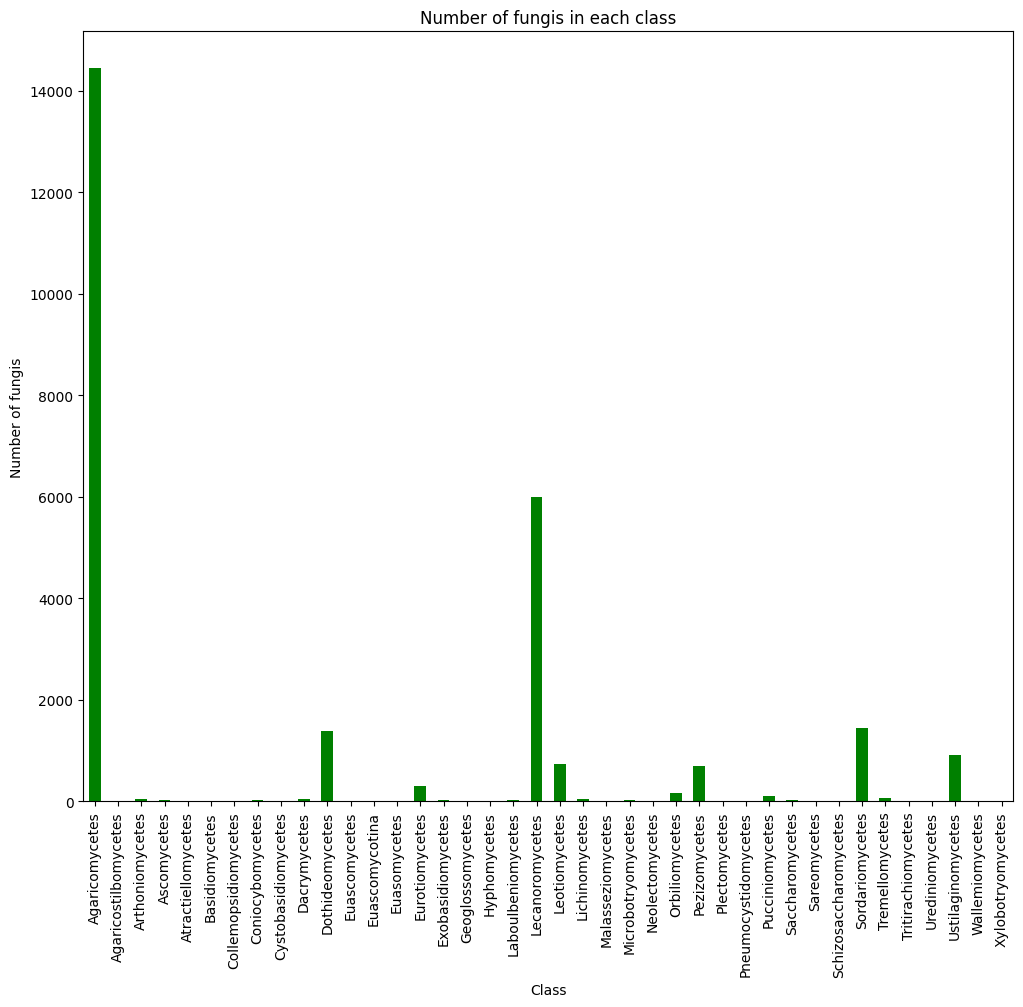

In [60]:
#We can make a plot of the number of fungis in each class, we will use the name_id to see how many fungis are in each class
fungus_classes_counts = fungus_types_df['class'].value_counts()
fungus_classes_counts = fungus_classes_counts.sort_index()
fungus_classes_counts.plot(kind='bar', figsize=(12, 10), title='Number of fungis in each class', xlabel='Class', ylabel='Number of fungis', color='green')

Chcemy teraz spośród tych wszystkich klas wyodrębnić te które występują najczęściej i są chętnie zbierane

Po researchu wyodrębniłem klasy które występują często oraz są porządane przez zbieraczy grzybów:
1. Ascomycota:
    - Pezizomycetes (dużo grzybów jadalnych jest w tej klasie, które są poszukiwane)
2. Basidiomycota:
    - Agaricomycetes (bardzo dużo grzybów jadalnych, jest też sporo dziwnych odmian ale jest to nasza główna klasa więc 100% zostawiamy, potencjalnie do dalszego filtrowania)
    
Takie, które mogą być przydatne do rozpoznania, choć nie są powszechnie zbierane:
1. Ascomycota:
    - Arthoniomycetes (porosty)
    - Ascomycetes (chyba to klasa taka ogólna, parę grzybów z tej klasy w naszym datasecie jest rzadka ale mają dobry potencjał do trenowania - dobrej jakości zdjęcia)
    - Leotiomycetes (patyczniaki, jest ich dużo ale są bardzo zdywersyfikowane, większość się nie zbiera i mają zdjęcia średniej jakości ale trzymam je tu bo mamy ich sporo)
2. Basidiomycota:
    - Dacrymycetes (popularne grzyby aczkolwiek są małe i pasożytnicze, niezbieralne spożywczo)
    - Geoglossomycetes (mała klasa, bardzo charakterystyczna, często zbiera się ją kolekcjonersko ze względu na jej wygląd i całkiem rzadkie występowanie)
    - Tremellomycetes (charakterystyczne i niektóre gatunki są wykorzystywane w przemyśle spożywczym oraz farmaceutycznym, raczej nie zbiera się ich na codzień ale można pomyśleć nad pozostawieniem ich jako ciekawy dodatek )
    
Takie, których na spokojnie można się pozbyć, nikt poza ekstremalnymi fanami nie będzie ich zbierał
1. Ascomycota:
    - Dorthideomycetes (głównie pasożyty)
    - Sordariomycetes (mało popularne, czasem się je zbiera do wykorzystania w medycynie tradycyjnej ale nie mają wartości kolekcjonerskiej/spożywczej)
    - Eurotiomycetas (nie nadają się do zbierania za bardzo, niespotykane)
    - Lecanoromycetes (porosty)
    - Laboulbeniomycetes (owadorośla - nieprzydatne nam)
    - Saccharomycetes (drożdże)
    - Euascomycetes (nie wiem co to za klasa, jakaś dziwna w naszym datasecie nawet nie ma grzybów z niej - do usunięcia)
    - Euascomycotina (mała klasa, nie będąca obiektem poszukiwań przeciętnych grzybiarzy)
    - Neolectomycetes (mała klasa, rzadko występuje w Europie, choć ma całkiem ciekawe grzyby, jednak nie przydadzą nam się)
    - Orbiliomycetes (klasa grzybów drapieżnych, niezbieralne)
    - Plectomycetes (bakterie)
    - Pneumocysomycetes (bakterie, mogą być w ludzkich płucach :O )
    - Sareomycetes (bardzo mało info więc zakładam że nieprzydatna z punktu widzenia zbieractwa)
    - Schizosaccharomycetes (dziwadła, niepopularne i niezbieralne)
    - Xylobotromycetes (pasożyty)
    - Collemopsidiomycetes (rzadkie grzyby, niespotykane raczej w Europie)
    - Coniocybomycetes (żyją w symbiozie z drzewami, mała klasa, raczej nie jest celem grzybiarzy)
    - Lichinomycetes (żyją z sinicami i tworzą porosty, do usunięcia)
2. Basidiomycota:
    - Atractiellomycetes (mała klasa, zawiera pasożyty i grzyby do bardziej naukowych badań)
    - Malasseziomycetes (podobnie jak powyższa, nie nadaje się do zbieractwa)
    - Tritirachiomycetes (mała klasa o jednym gatunku, niezbieralny spożywczo)
    - Hyphomycetes (dużo pleśni, całkiem często spotykane ale nie są zbierane ani wykorzystywane spożywczo)
    - Urediniomycetes (podklasa rdzy)
    - Ustilaginomycetes (pasożyty, niepotrzebne nam)
    - Agaricostilbomycetes (całkiem nowa klasa, mało przykładów, niepotrzebne)
    - Exobasidiomycetes (pasożyty roślinne)
    - Wallemiomycetes (malutkie grzyby, nowa klasa, spotykane w jedzeniu)
    - Pucciniomycetes (rdze, bleh)
    - Cystobasidiomycetes (też coś wspólnego ze rdzą mają to nie bierzemey pod uwagę)

In [61]:
#So after this we have few classes that we want to keep and that are: Pezizomycetes, Agaricomycetes,
#Arthoniomycetes, Ascomycetes, Leotiomycetes, Dacrymycetes, Geoglossomycetes, Tremellomycetes
#The rest of the classes we will delete from our dataset, we will make a list of the classes that we want to delete

delete_fungus_classes = fungus_classes[~np.isin(fungus_classes, ['Pezizomycetes', 'Agaricomycetes', 'Arthoniomycetes', 'Ascomycetes', 'Leotiomycetes', 'Dacrymycetes', 'Geoglossomycetes', 'Tremellomycetes'])]
delete_fungus_classes


array(['Agaricostilbomycetes', 'Atractiellomycetes', 'Basidiomycetes',
       'Collemopsidiomycetes', 'Coniocybomycetes', 'Cystobasidiomycetes',
       'Dothideomycetes', 'Euascomycetes', 'Euascomycotina',
       'Euasomycetes', 'Eurotiomycetes', 'Exobasidiomycetes',
       'Hyphomycetes', 'Laboulbeniomycetes', 'Lecanoromycetes',
       'Lichinomycetes', 'Malasseziomycetes', 'Microbotryomycetes',
       'Neolectomycetes', 'Orbiliomycetes', 'Plectomycetes',
       'Pneumocystidomycetes', 'Pucciniomycetes', 'Saccharomycetes',
       'Sareomycetes', 'Schizosaccharomycetes', 'Sordariomycetes',
       'Tritirachiomycetes', 'Urediniomycetes', 'Ustilaginomycetes',
       'Wallemiomycetes', 'Xylobotryomycetes'], dtype=object)

In [65]:
#Now we will do the same process as we did with the non-fungus types and with the fungi phylums. We will get the genus names of the fungis that are in the classes that we want to delete

del_class_list = []
del_class_df = fungus_types_df[fungus_types_df['class'].isin(delete_fungus_classes)]

for id in del_class_df['name_id']:
    del_class_list.append(fungus_genus_names_df[fungus_genus_names_df['id'] == id]['text_name'].values[0])
del_class_list

['Xylaria polymorpha group',
 'Xylaria magnoliae',
 'Xylaria hypoxylon group',
 'Neolecta irregularis',
 'Hypomyces lactifluorum',
 'Hypomyces cervinigenus',
 'Exobasidium vaccinii',
 'Sphaerophorus globosus',
 'Cladonia asahinae',
 'Cladonia macilenta',
 'Letharia vulpina',
 'Lobaria pulmonaria',
 'Cladonia',
 'Cordyceps',
 'Exobasidium',
 'Hypogymnia',
 'Hypomyces',
 'Hypoxylon',
 'Letharia',
 'Lobaria',
 'Neolecta',
 'Ochrolechia',
 'Parmotrema',
 'Pseudocyphelaria',
 'Ramalina',
 'Sphaerophorus',
 'Xylaria',
 'Hypomyces hyalinus',
 'Camarops',
 'Camarops petersii',
 'Polyporus varius',
 'Daldinia',
 'Elaphomyces',
 'Elaphomyces muricatus',
 'Orbilia',
 'Cordyceps entomorrhiza',
 'Cordyceps gracilis',
 'Cordyceps myrmecophila',
 'Cordyceps sphecocephala',
 'Cordyceps unilateralis',
 'Elaphomyces granulatus',
 'Elaphomyces subviscidus',
 'Hypomyces luteovirens',
 'Hypomyces transformans',
 'Sepedonium',
 'Nectriopsis',
 'Neolecta vitellina',
 'Penicillium',
 'Podostroma',
 'Podostrom

In [69]:
len(del_class_list)

10559

In [70]:
del_class_list = clean_genus_names(del_class_list)
del_class_list

['Xylaria_polymorpha',
 'Xylaria_magnoliae',
 'Xylaria_hypoxylon',
 'Neolecta_irregularis',
 'Hypomyces_lactifluorum',
 'Hypomyces_cervinigenus',
 'Exobasidium_vaccinii',
 'Sphaerophorus_globosus',
 'Cladonia_asahinae',
 'Cladonia_macilenta',
 'Letharia_vulpina',
 'Lobaria_pulmonaria',
 'Cladonia',
 'Cordyceps',
 'Exobasidium',
 'Hypogymnia',
 'Hypomyces',
 'Hypoxylon',
 'Letharia',
 'Lobaria',
 'Neolecta',
 'Ochrolechia',
 'Parmotrema',
 'Pseudocyphelaria',
 'Ramalina',
 'Sphaerophorus',
 'Xylaria',
 'Hypomyces_hyalinus',
 'Camarops',
 'Camarops_petersii',
 'Polyporus_varius',
 'Daldinia',
 'Elaphomyces',
 'Elaphomyces_muricatus',
 'Orbilia',
 'Cordyceps_entomorrhiza',
 'Cordyceps_gracilis',
 'Cordyceps_myrmecophila',
 'Cordyceps_sphecocephala',
 'Cordyceps_unilateralis',
 'Elaphomyces_granulatus',
 'Elaphomyces_subviscidus',
 'Hypomyces_luteovirens',
 'Hypomyces_transformans',
 'Sepedonium',
 'Nectriopsis',
 'Neolecta_vitellina',
 'Penicillium',
 'Podostroma',
 'Podostroma_alutaceum'

In [75]:
#Lets see how many mushrooms we will delete from our dataset
catalog_names = os.listdir(images_dir)

matching_values = [value for value in del_class_list if value in catalog_names]
count = len(matching_values)
print(f"The number of values in your list that match the names of the catalogs in your images_dir is: {count}")

The number of values in your list that match the names of the catalogs in your images_dir is: 837


In [76]:
#Delete the fungis from our dataset based on their names in the classes that we want to delete
delete_fungus(del_class_list, images_dir)

Deleted Acarospora
Deleted Acarospora_boulderensis
Deleted Acarospora_fuscata
Deleted Acarospora_glaucocarpa
Deleted Acarospora_nodulosa
Deleted Acarospora_obnubila
Deleted Acarospora_obpallens
Deleted Acarospora_placodiiformis
Deleted Acarospora_robiniae
Deleted Acarospora_schleicheri
Deleted Acarospora_socialis
Deleted Acarospora_stapfiana
Deleted Acarospora_strigata
Deleted Achroomyces
Deleted Achroomyces_vestitus
Deleted Acrocordia
Deleted Acrocordia_conoidea
Deleted Acrocordia_gemmata
Deleted Acrocordia_macrospora
Deleted Acrospermum_compressum
Deleted Ahtiana_aurescens
Deleted Akanthomyces
Deleted Akanthomyces_aculeatus
Deleted Alectoria_fallacina
Deleted Alectoria_imshaugii
Deleted Alectoria_ochroleuca
Deleted Alectoria_sarmentosa
Deleted Alternaria
Deleted Alternaria_alternata
Deleted Alternaria_papavericola
Deleted Amphisphaeria_bufonia
Deleted Anisomeridium
Deleted Annulohypoxylon
Deleted Annulohypoxylon_annulatum
Deleted Annulohypoxylon_thouarsianum
Deleted Annulohypoxylon_t

In [77]:
subdirs = [os.path.join(images_dir, subdir) for subdir in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, subdir))]
len(subdirs)

6859

In [92]:
#Less than 100 mushrooms from our dataset were deleted, which is not enough to make a big difference. 
#I noticed that some mushrooms that needed to be deleted dont have its corresponding id in the names.csv file, so we need to check which ones are missing


#TODO: Correct the matching values
# fungus_names_ids = fungus_genus_names_df['id']
# fungus_types_id = fungus_types_df['name_id']

# unmatched_ids = [id for id in fungus_names_ids if id not in fungus_types_id]
# unmatched_ids

[5,
 7,
 8,
 11,
 14,
 15,
 16,
 44,
 66,
 67,
 124,
 125,
 126,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 173,
 174,
 175,
 187,
 202,
 203,
 204,
 205,
 206,
 207,
 209,
 210,
 211,
 217,
 231,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 257,
 258,
 282,
 297,
 302,
 310,
 321,
 333,
 349,
 353,
 354,
 355,
 356,
 364,
 369,
 377,
 395,
 417,
 436,
 440,
 445,
 458,
 460,
 464,
 473,
 477,
 479,
 480,
 488,
 489,
 495,
 498,
 502,
 503,
 504,
 506,
 507,
 510,
 518,
 520,
 530,
 532,
 535,
 543,
 553,
 561,
 569,
 588,
 625,
 636,
 637,
 649,
 650,
 660,
 665,
 672,
 675,
 676,
 689,
 691,
 692,
 693,
 705,
 712,
 726,
 728,
 730,
 734,
 737,
 744,
 752,
 753,
 758,
 759,
 791,
 794,
 798,
 799,
 800,
 801,
 803,
 810,
 817,
 821,
 825,
 828,
 829,
 831,
 835,
 837,
 838,
 841,
 842,
 848,
 875,
 881,
 885,
 886,
 892,
 899,
 901,
 902,
 909,
 910,
 915,
 953,
 954,
 955,
 956,
 957,
 1023,
 1024,
 1034,
 1044,
 1045,
 1049,
 1050,
 1051,
 10

In [87]:
#Now that we have mushrooms ids that are not in the names.csv file we can try to delete them based on their name_id

unmatched_names = []
for id in unmatched_ids:
    matching_rows = fungus_genus_names_df[fungus_genus_names_df['id'] == id]
    if not matching_rows.empty:
        unmatched_names.append(matching_rows['text_name'].values[0])
unmatched_names

['Clavaria "redwood-coast"',
 'Amanita "sp-T49"',
 'Amanita "sp-MO07"',
 'Gymnopus confluens var. campanulatus',
 'Herpomyces',
 'Chlorophyllum molybdites var. luteolosperma',
 'Chlorophyllum molybdites var. molybdites',
 'Stropharia agrocyboides',
 'Morchella hispaniolensis',
 'Morchella gracilis',
 'Morchella peruviana',
 'Morchella rufobrunnea clade',
 'Pholiota luteobadia',
 'Hypocrea schweinitzii group',
 'Amanita labiliannulus',
 'Russula nympharum',
 'Pholiota subsaponacea',
 'Sclerogaster pacificus',
 'Sclerogaster gastrosporioides',
 'Tuckermanopsis americana',
 'Tuckermanopsis chlorophylla',
 'Tuckermanopsis ciliaris',
 'Tuckermanopsis orbata',
 'Tuckermanopsis platyphylla',
 'Tuckermanopsis sepincola',
 'Tuckermanopsis subalpina',
 'Masonhalea inermis',
 'Diplodia pinea',
 'Tricholoma matsutake group',
 'Truncospora fuscopurpurea',
 'Truncospora tephropora',
 'Phloeomana clavata',
 'Phloeomana hiemalis',
 'Phloeomana minutula',
 'Calyptella cernua',
 'Calyptella lactea',
 'R

In [88]:
len(unmatched_names)

7678

In [90]:
#We have the names of the mushrooms that are not in the names.csv file, we can try to delete them from our dataset to see if it makes a difference

unmatched_names = clean_genus_names(unmatched_names)
delete_fungus(unmatched_names, images_dir)

Deleted Agaricus_abruptibulbus
Deleted Agaricus_braendlei
Deleted Agaricus_floridanus
Deleted Agaricus_megalocarpus
Deleted Albatrellopsis_flettii
Deleted Alloclavaria_purpurea
Deleted Amanita
Deleted Amanita_audubonensis
Deleted Amanita_aureosorora
Deleted Amanita_aureosubucula
Deleted Amanita_austrowellsii
Deleted Amanita_batonrougensis
Deleted Amanita_calisorora
Deleted Amanita_chiricahuana
Deleted Amanita_clarionensis
Deleted Amanita_collisus
Deleted Amanita_constrictisorora
Deleted Amanita_dorothiae
Deleted Amanita_flavorubens
Deleted Amanita_gracilissima
Deleted Amanita_helmettensis
Deleted Amanita_jakeslandingensis
Deleted Amanita_junquillea
Deleted Amanita_labiliannulus
Deleted Amanita_lear
Deleted Amanita_lindgreniana
Deleted Amanita_longicuneoides
Deleted Amanita_longicuneus
Deleted Amanita_muscaria
Deleted Amanita_neocaesariensis
Deleted Amanita_oakmanensis
Deleted Amanita_obconicobasis
Deleted Amanita_pantherina
Deleted Amanita_rhopalopus
Deleted Amanita_sarahae
Deleted Ama

In [91]:
subdirs = [os.path.join(images_dir, subdir) for subdir in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, subdir))]
len(subdirs)

6539

TODO: Correct matching ids!!!!, download again images (because vs code git deleted images from dozens of first directories :DD ), check if deleting mushrooms with missing ids is actually good, find a way to optimize mushrooms in dataset even more!!

In [ ]:
# Check if in each subdirectory there are more than 5 images
for subdir in subdirs:
    # list of all image files in subdirectory
    images = [img for img in os.listdir(subdir) if img.endswith('.jpg')]

    # if there are less than 5 images in the subdirectory, create a randomly flipped copy of each image in this subdirectory
    if len(images) <= 4:
        for img in images:
            img_path = os.path.join(subdir, img)
            flipped_img = Image.open(img_path).transpose(Image.FLIP_LEFT_RIGHT)
            flipped_img.save(os.path.join(subdir, img.replace('.jpg', '_flipped.jpg')))
            print(f'Created flipped image for {img_path} in {subdir}')


In [5]:
# if you ran previous cell again, there will be duplicates named *_flipped_flipped.jpg, we cant have that so we remove them

import glob
path = images_dir
files = glob.glob(os.path.join(path, '**/*_flipped_flipped.jpg'), recursive=True)

for f in files:
    os.remove(f)

print('Removed all double flipped images')

Removed all double flipped images
